# Importar librerias

In [2]:
# imports time series
import pandas as pd
import numpy as np
import seaborn as sns

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import webbrowser
import pickle

# Cargar datos

In [3]:
PATH = "..\CSV\df_final_fechas_14102023.csv"

df= pd.read_csv(PATH)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item        object 
 2   category    object 
 3   department  object 
 4   store       object 
 5   store_code  object 
 6   region      object 
 7   date        object 
 8   ventas      int64  
 9   event       int64  
 10  price       float64
 11  revenue     float64
dtypes: float64(2), int64(2), object(8)
memory usage: 764.9+ MB


In [5]:
df.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
ventas        0
event         0
price         0
revenue       0
dtype: int64

# EDA

In [6]:
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')

In [7]:
df['id'].nunique()

30490

In [8]:
MIN_DATE = df['date'].min()
MAX_DATE = df['date'].max()

In [9]:
print(f'Min date es {MIN_DATE}\nMax date es {MAX_DATE}')

Min date es 2011-01-30 00:00:00
Max date es 2016-04-24 00:00:00


In [10]:
df.sample(3)

,id,item,category,department,store,store_code,region,date,ventas,event,price,revenue
278760,ACCESORIES_1_106_PHI_1,ACCESORIES_1_106,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2013-01-13,5,0,3.4181,17.0905
3670736,HOME_&_GARDEN_2_244_NYC_4,HOME_&_GARDEN_2_244,HOME_&_GARDEN,HOME_&_GARDEN_2,Brooklyn,NYC_4,New York,2015-07-12,2,0,4.9625,9.9250
1497169,ACCESORIES_2_131_NYC_2,ACCESORIES_2_131,ACCESORIES,ACCESORIES_2,Harlem,NYC_2,New York,2011-09-18,1,0,7.9401,7.9401


In [11]:
df_anios = sorted(list(df['date'].unique()))[-121:]  #Cogeremos des del 2014 para que nuestro modelo haga las predicciones
df_anios = df[df['date'].isin(df_anios)]

In [12]:
df_anios_final = df_anios.copy()

In [13]:
sample_id = df_anios[df_anios['id']=='SUPERMARKET_2_044_NYC_2']

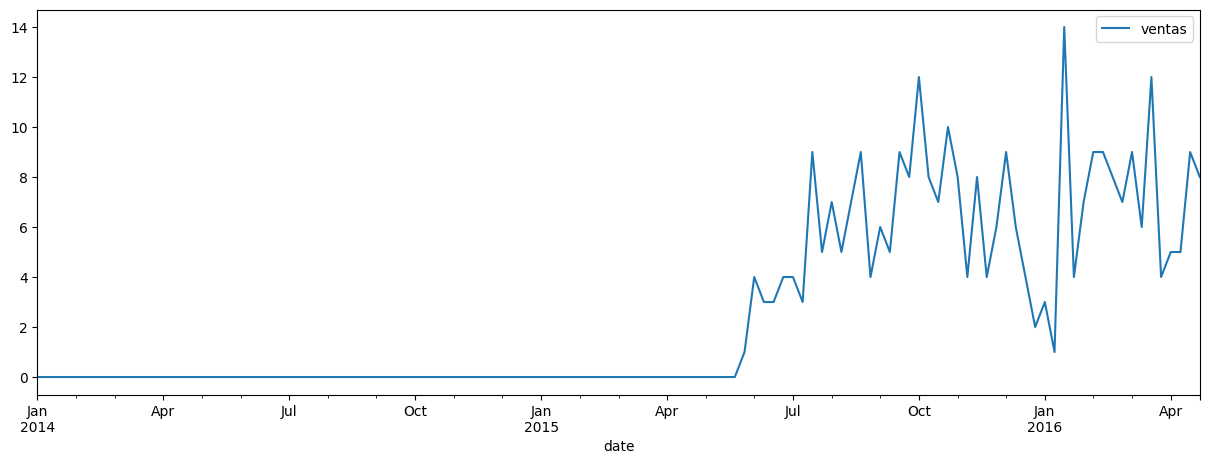

In [14]:
sample_id_plt=sample_id[['date','ventas']]
sample_id_plt.set_index('date').plot(figsize=(15,5));

In [15]:
sample_id[(sample_id['ventas']!=0)]['date'].nunique()

48

In [16]:
sample_id[(sample_id['ventas']<1)]['date'].nunique()

73

In [17]:
df_anios.describe(exclude = np.number).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
id,3689290,30490,ACCESORIES_1_001_BOS_1,121,NaT,NaT,NaT,NaT,NaT,NaT
item,3689290,3049,ACCESORIES_1_001,1210,NaT,NaT,NaT,NaT,NaT,NaT
category,3689290,3,SUPERMARKET,1738770,NaT,NaT,NaT,NaT,NaT,NaT
department,3689290,7,SUPERMARKET_3,995830,NaT,NaT,NaT,NaT,NaT,NaT
store,3689290,10,South_End,368929,NaT,NaT,NaT,NaT,NaT,NaT
store_code,3689290,10,BOS_1,368929,NaT,NaT,NaT,NaT,NaT,NaT
region,3689290,3,New York,1475716,NaT,NaT,NaT,NaT,NaT,NaT
date,3689290,NaN,NaN,NaN,2015-02-28 23:59:59.999999232,2014-01-05,2014-08-03,2015-03-01,2015-09-27,2016-04-24


In [18]:
df_anios.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
ventas,3689290.0,8.594699,21.841258,0.000,0.0000,3.000,9.0000,1516.0000
event,3689290.0,0.107438,0.309669,0.000,0.0000,0.000,0.0000,1.0000
price,3689290.0,5.591363,4.554778,0.012,2.6201,4.225,7.1760,60.9750
revenue,3689290.0,31.852641,75.760545,0.000,0.0000,13.536,35.1918,6968.4552


In [19]:
df_anios[df_anios['price']>100]

,id,item,category,department,store,store_code,region,date,ventas,event,price,revenue


In [20]:
TARGET = 'ventas'
describe_df_target = df_anios[TARGET].describe()
describe_df_target

count    3.689290e+06
mean     8.594699e+00
std      2.184126e+01
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      1.516000e+03
Name: ventas, dtype: float64

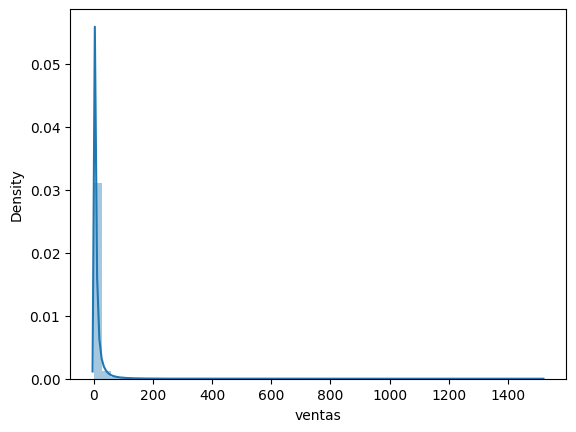

In [21]:
sns.distplot(df_anios[TARGET]);

In [22]:
df_anios

,id,item,category,department,store,store_code,region,date,ventas,event,price,revenue
153,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-05,1,1,10.9858,10.9858
154,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-12,0,0,10.9858,0.0000
155,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-19,1,0,10.9858,10.9858
156,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-26,3,0,10.9858,32.9574
157,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-02-02,0,1,10.9858,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
8354255,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-03-27,17,1,1.2000,20.4000
8354256,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-03,22,0,1.2000,26.4000
8354257,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-10,8,0,1.2000,9.6000
8354258,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-17,0,0,1.2000,0.0000


# Preprocessing (cat->num)

In [23]:
le = LabelEncoder()
df_anios['category_INT']= le.fit_transform(df_anios['category'])
df_anios['department_INT']= le.fit_transform(df_anios['department'])
df_anios['store_INT']= le.fit_transform(df_anios['store'])
df_anios['region_INT']= le.fit_transform(df_anios['region'])
df_anios['item_INT'] = le.fit_transform(df_anios['item'])

In [25]:
df_anios['year'] = df_anios['date'].dt.year
df_anios['week'] = df_anios['date'].dt.isocalendar().week 
df_anios['month'] = df_anios['date'].dt.month

In [26]:
df_final = df_anios.copy()

In [27]:
df_anios['ventas'].fillna(0,inplace = True)

In [28]:
def plot_ts_acf_pacf(y,title):

  fig = plt.figure(figsize = (12,10))
  ax1,ax2,ax3 = fig.subplots(3,1)

  ax1.plot(y)
  plot_acf(x=y,ax =ax2, lags = 14)
  plot_pacf(x=y,ax =ax3, lags = 14)

  plt.suptitle(t=title,fontsize=20)

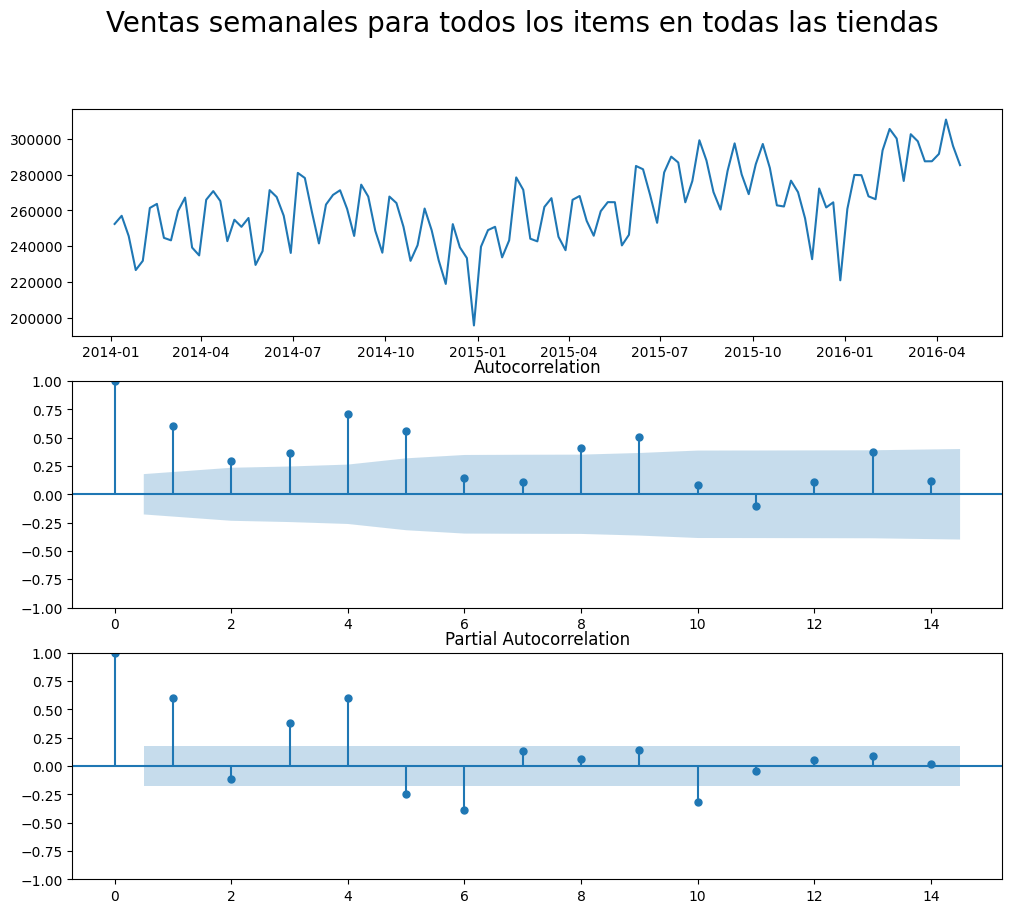

In [29]:
y = df_anios.set_index('date').resample('W')['ventas'].sum()
plot_ts_acf_pacf(y=y,title ="Ventas semanales para todos los items en todas las tiendas" );

In [30]:
# Cantidad lags y mm a probar

## lags = [2,3,4,5,6,7,8,9,11,12,13]
## mm = [2,3,4,5,6,7,8,9,10,11,13]

# REFACTOR para construcción variables

In [31]:
def build_ts_vars(dataframe,gb_list,target_column,agg_func,agg_func_name):

  assert 'date' in dataframe.columns.tolist(), 'Date must be in df columns'
  assert isinstance(gb_list,list), 'Error, must be a list'

  new_name = '_'.join(gb_list+[target_column]+ [agg_func_name])

  gb_df = (
      dataframe
      .set_index('date')
      .groupby(gb_list)
      .resample('W')[target_column]
      .apply(agg_func)
      .to_frame()
      .reset_index()
      .rename(
          columns = {
              target_column:new_name
          }
      )

  )
  gb_df[f'{new_name}_lag2'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(2)
  )

  gb_df[f'{new_name}_lag3'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(3)
  )
  gb_df[f'{new_name}_lag5'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(5)
  )

    ### media móvil

  gb_df[f'{new_name}_m2'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(2).rolling(window = 3).mean()
  )

  gb_df[f'{new_name}_m4'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(4).rolling(window = 3).mean()
  )


  print(f'Dropping columns that might cause target leakage')
  gb_df.drop(new_name, inplace = True, axis=1)


  return gb_df

In [32]:
df_anios.head(1)

,id,item,category,department,store,store_code,region,date,ventas,event,price,revenue,category_INT,department_INT,store_INT,region_INT,item_INT,year,week,month
153,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-05,1,1,10.9858,10.9858,0,0,7,0,0,2014,1,1


In [33]:
GB_LIST_1 = ['id']
TARGET_COLUMN_1 = 'ventas'
AGG_FUNC_1 = np.sum
AGG_FUNC_NAME_1 = 'sum'

vars_ts_1= build_ts_vars(
dataframe = df_anios,
gb_list = GB_LIST_1,
target_column = TARGET_COLUMN_1,
agg_func = AGG_FUNC_1,
agg_func_name = AGG_FUNC_NAME_1,
)
vars_ts_1.head(10)

Dropping columns that might cause target leakage


,id,date,id_ventas_sum_lag2,id_ventas_sum_lag3,id_ventas_sum_lag5,id_ventas_sum_m2,id_ventas_sum_m4
0,ACCESORIES_1_001_BOS_1,2014-01-05,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,2014-01-12,NaN,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,2014-01-19,1.0,NaN,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,2014-01-26,0.0,1.0,NaN,NaN,NaN
4,ACCESORIES_1_001_BOS_1,2014-02-02,1.0,0.0,NaN,0.666667,NaN
5,ACCESORIES_1_001_BOS_1,2014-02-09,3.0,1.0,1.0,1.333333,NaN
6,ACCESORIES_1_001_BOS_1,2014-02-16,0.0,3.0,0.0,1.333333,0.666667
7,ACCESORIES_1_001_BOS_1,2014-02-23,1.0,0.0,1.0,1.333333,1.333333
8,ACCESORIES_1_001_BOS_1,2014-03-02,2.0,1.0,3.0,1.000000,1.333333
9,ACCESORIES_1_001_BOS_1,2014-03-09,1.0,2.0,0.0,1.333333,1.333333


In [34]:
GB_LIST_2 = ['id']
TARGET_COLUMN_2 = 'price'
AGG_FUNC_2 = np.sum
AGG_FUNC_NAME_2 = 'sum'

vars_ts_2= build_ts_vars(
dataframe = df_anios,
gb_list = GB_LIST_2,
target_column = TARGET_COLUMN_2,
agg_func = AGG_FUNC_2,
agg_func_name = AGG_FUNC_NAME_2,
)
vars_ts_2.head(10)

Dropping columns that might cause target leakage


,id,date,id_price_sum_lag2,id_price_sum_lag3,id_price_sum_lag5,id_price_sum_m2,id_price_sum_m4
0,ACCESORIES_1_001_BOS_1,2014-01-05,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,2014-01-12,NaN,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,2014-01-19,10.9858,NaN,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,2014-01-26,10.9858,10.9858,NaN,NaN,NaN
4,ACCESORIES_1_001_BOS_1,2014-02-02,10.9858,10.9858,NaN,10.9858,NaN
5,ACCESORIES_1_001_BOS_1,2014-02-09,10.9858,10.9858,10.9858,10.9858,NaN
6,ACCESORIES_1_001_BOS_1,2014-02-16,10.9858,10.9858,10.9858,10.9858,10.9858
7,ACCESORIES_1_001_BOS_1,2014-02-23,10.9858,10.9858,10.9858,10.9858,10.9858
8,ACCESORIES_1_001_BOS_1,2014-03-02,10.9858,10.9858,10.9858,10.9858,10.9858
9,ACCESORIES_1_001_BOS_1,2014-03-09,10.9858,10.9858,10.9858,10.9858,10.9858


In [35]:
GB_LIST_3 = ['id']
TARGET_COLUMN_3 = 'revenue'
AGG_FUNC_3 = np.mean
AGG_FUNC_NAME_3 = 'mean'

vars_ts_3= build_ts_vars(
dataframe = df_anios,
gb_list = GB_LIST_3,
target_column = TARGET_COLUMN_3,
agg_func = AGG_FUNC_3,
agg_func_name = AGG_FUNC_NAME_3,
)
vars_ts_3.head(10)

Dropping columns that might cause target leakage


,id,date,id_revenue_mean_lag2,id_revenue_mean_lag3,id_revenue_mean_lag5,id_revenue_mean_m2,id_revenue_mean_m4
0,ACCESORIES_1_001_BOS_1,2014-01-05,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,2014-01-12,NaN,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,2014-01-19,10.9858,NaN,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,2014-01-26,0.0000,10.9858,NaN,NaN,NaN
4,ACCESORIES_1_001_BOS_1,2014-02-02,10.9858,0.0000,NaN,7.323867,NaN
5,ACCESORIES_1_001_BOS_1,2014-02-09,32.9574,10.9858,10.9858,14.647733,NaN
6,ACCESORIES_1_001_BOS_1,2014-02-16,0.0000,32.9574,0.0000,14.647733,7.323867
7,ACCESORIES_1_001_BOS_1,2014-02-23,10.9858,0.0000,10.9858,14.647733,14.647733
8,ACCESORIES_1_001_BOS_1,2014-03-02,21.9716,10.9858,32.9574,10.985800,14.647733
9,ACCESORIES_1_001_BOS_1,2014-03-09,10.9858,21.9716,0.0000,14.647733,14.647733


## Join full_df con variables auxuliares

In [36]:
print(df_anios.shape)

df_anios = pd.merge(df_anios,vars_ts_1, on = ['date'] + GB_LIST_1, how = 'left')

print(df_anios.shape)

(3689290, 20)
(3689290, 25)


In [37]:
print(df_anios.shape)

df_anios = pd.merge(df_anios,vars_ts_2, on = ['date'] + GB_LIST_2, how = 'left')

print(df_anios.shape)

(3689290, 25)
(3689290, 30)


In [38]:
print(df_anios.shape)

df_anios = pd.merge(df_anios,vars_ts_3, on = ['date'] + GB_LIST_3, how = 'left')

print(df_anios.shape)

(3689290, 30)
(3689290, 35)


In [39]:
df_anios.set_index('id',inplace=True)

In [40]:
df_anios.head(3)

,item,category,department,store,store_code,region,date,ventas,event,price,...,id_price_sum_lag2,id_price_sum_lag3,id_price_sum_lag5,id_price_sum_m2,id_price_sum_m4,id_revenue_mean_lag2,id_revenue_mean_lag3,id_revenue_mean_lag5,id_revenue_mean_m2,id_revenue_mean_m4
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-05,1,1,10.9858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-12,0,0,10.9858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2014-01-19,1,0,10.9858,...,10.9858,NaN,NaN,NaN,NaN,10.9858,NaN,NaN,NaN,NaN


## Drop columns

In [41]:
df_anios.columns.to_list()

['item',
 'category',
 'department',
 'store',
 'store_code',
 'region',
 'date',
 'ventas',
 'event',
 'price',
 'revenue',
 'category_INT',
 'department_INT',
 'store_INT',
 'region_INT',
 'item_INT',
 'year',
 'week',
 'month',
 'id_ventas_sum_lag2',
 'id_ventas_sum_lag3',
 'id_ventas_sum_lag5',
 'id_ventas_sum_m2',
 'id_ventas_sum_m4',
 'id_price_sum_lag2',
 'id_price_sum_lag3',
 'id_price_sum_lag5',
 'id_price_sum_m2',
 'id_price_sum_m4',
 'id_revenue_mean_lag2',
 'id_revenue_mean_lag3',
 'id_revenue_mean_lag5',
 'id_revenue_mean_m2',
 'id_revenue_mean_m4']

In [42]:
COLUMNS_TO_DROP = [
    'item',
    'category',
    'department',
    'store',
    'store_code',
    'region',
    'revenue'



]
df_anios.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [43]:
df_anios.head(3)

,date,ventas,event,price,category_INT,department_INT,store_INT,region_INT,item_INT,year,...,id_price_sum_lag2,id_price_sum_lag3,id_price_sum_lag5,id_price_sum_m2,id_price_sum_m4,id_revenue_mean_lag2,id_revenue_mean_lag3,id_revenue_mean_lag5,id_revenue_mean_m2,id_revenue_mean_m4
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,2014-01-05,1,1,10.9858,0,0,7,0,0,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,2014-01-12,0,0,10.9858,0,0,7,0,0,2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,2014-01-19,1,0,10.9858,0,0,7,0,0,2014,...,10.9858,NaN,NaN,NaN,NaN,10.9858,NaN,NaN,NaN,NaN


# Correlación datos

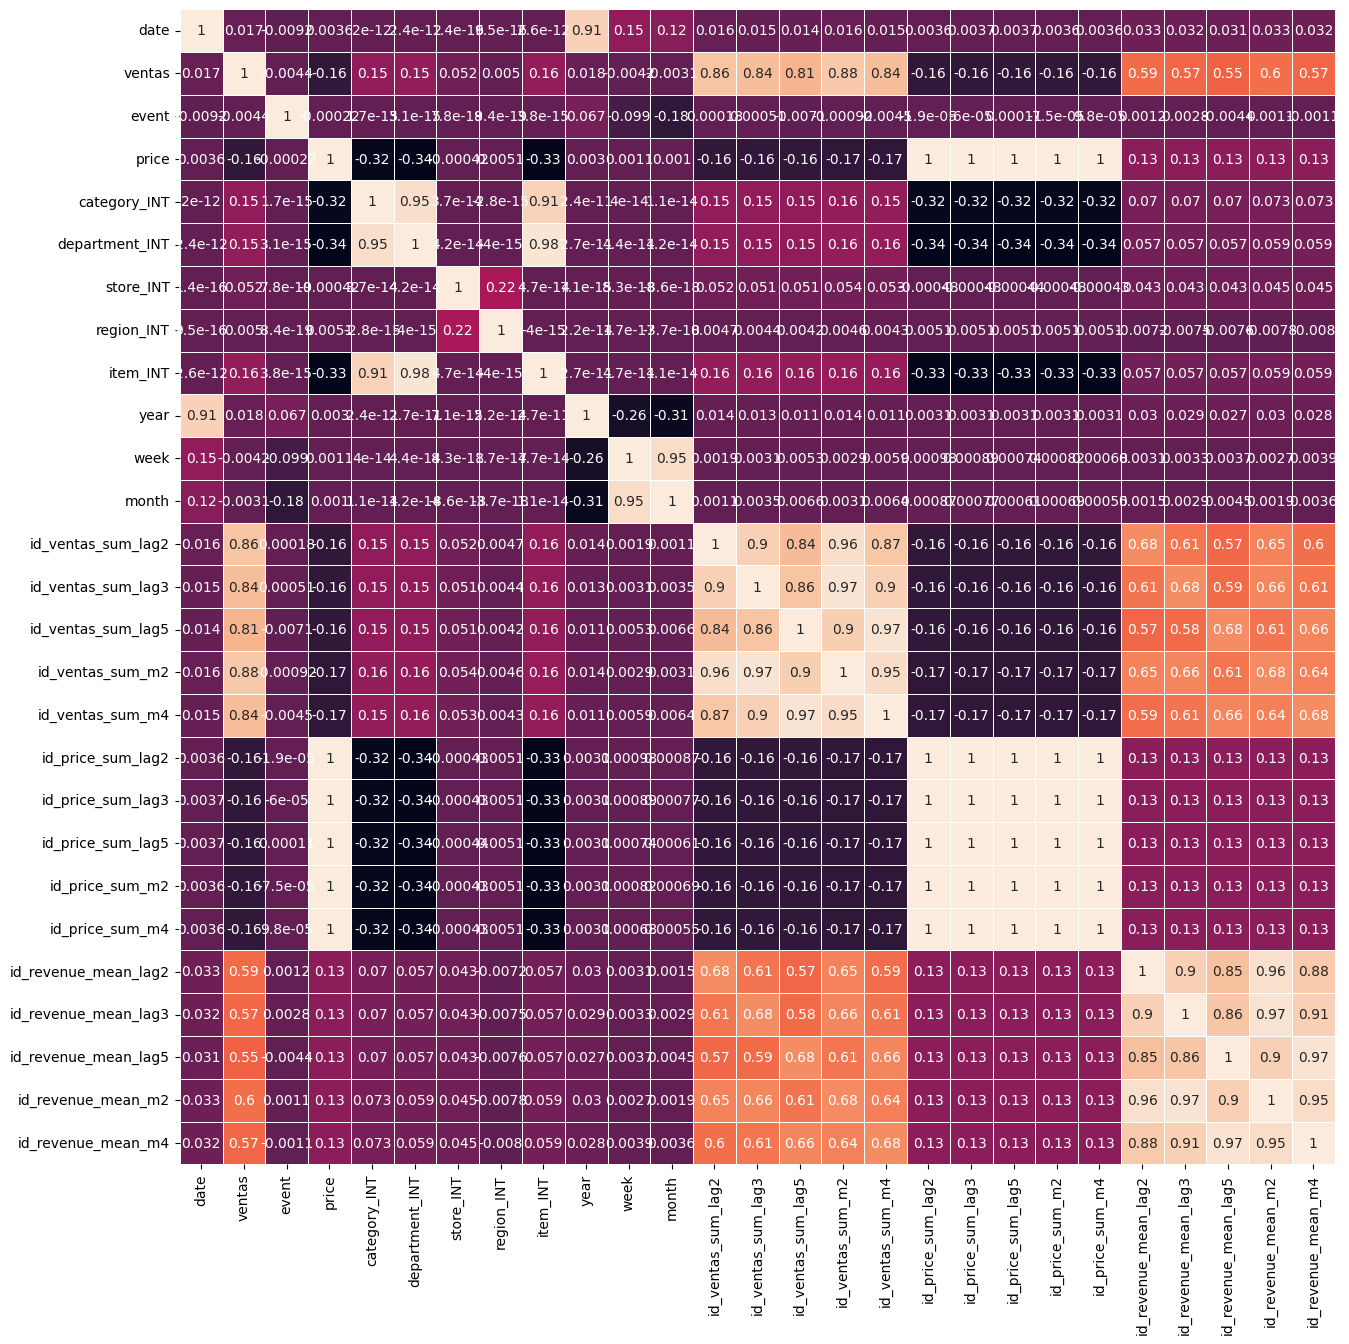

In [44]:
plt.figure(figsize=(20,15))
corr_matrix = df_anios.corr()
sns.heatmap(corr_matrix, annot=True,fmt='.2g',linewidth=.5,cbar=False,square=True)
plt.show()

# Train - Test Split

In [45]:
train_index = sorted(list(df_anios['date'].unique()))[:-8]
valida_index = sorted(list(df_anios['date'].unique()))[-8:-4]
test_index = sorted(list(df_anios['date'].unique()))[-4:]

In [46]:
print(f'Nuestro train index es {train_index}')
print(f'Nuestro valida index es {valida_index}')
print(f'Nuestro test index es {test_index}')

Nuestro train index es [Timestamp('2014-01-05 00:00:00'), Timestamp('2014-01-12 00:00:00'), Timestamp('2014-01-19 00:00:00'), Timestamp('2014-01-26 00:00:00'), Timestamp('2014-02-02 00:00:00'), Timestamp('2014-02-09 00:00:00'), Timestamp('2014-02-16 00:00:00'), Timestamp('2014-02-23 00:00:00'), Timestamp('2014-03-02 00:00:00'), Timestamp('2014-03-09 00:00:00'), Timestamp('2014-03-16 00:00:00'), Timestamp('2014-03-23 00:00:00'), Timestamp('2014-03-30 00:00:00'), Timestamp('2014-04-06 00:00:00'), Timestamp('2014-04-13 00:00:00'), Timestamp('2014-04-20 00:00:00'), Timestamp('2014-04-27 00:00:00'), Timestamp('2014-05-04 00:00:00'), Timestamp('2014-05-11 00:00:00'), Timestamp('2014-05-18 00:00:00'), Timestamp('2014-05-25 00:00:00'), Timestamp('2014-06-01 00:00:00'), Timestamp('2014-06-08 00:00:00'), Timestamp('2014-06-15 00:00:00'), Timestamp('2014-06-22 00:00:00'), Timestamp('2014-06-29 00:00:00'), Timestamp('2014-07-06 00:00:00'), Timestamp('2014-07-13 00:00:00'), Timestamp('2014-07-20 00

In [47]:
# Guardamos estas fechas para plot después

In [48]:
fechas_train = df_anios[df_anios['date'].isin(train_index)].drop(df_anios.iloc[:,1:],axis = 1)
fechas_valida = df_anios[df_anios['date'].isin(valida_index)].drop(df_anios.iloc[:,1:],axis = 1)
fechas_test = df_anios[df_anios['date'].isin(test_index)].drop(df_anios.iloc[:,1:],axis = 1)

In [49]:
fecha_reverse_diff = '2016-03-27'

In [50]:
# Dividimos train, valida y test

In [51]:
X_train = df_anios[df_anios['date'].isin(train_index)].drop(['ventas','date'],axis=1)
Y_train = df_anios[df_anios['date'].isin(train_index)]['ventas']

X_valida = df_anios[df_anios['date'].isin(valida_index)].drop(['ventas','date'],axis=1)
Y_valida = df_anios[df_anios['date'].isin(valida_index)]['ventas']

X_test = df_anios[df_anios['date'].isin(test_index)].drop(['ventas','date'],axis=1)
Y_test = df_anios[df_anios['date'].isin(test_index)]['ventas']

In [52]:
X_train.fillna(0,inplace=True)

# Model train

In [53]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 42)

# RMSE EVALUATION

In [54]:
%%time
model.fit(
    X_train,Y_train,
    eval_set = [(X_train,Y_train), (X_valida,Y_valida)],
    verbose = True,
)

[0]	validation_0-rmse:17.26647	validation_1-rmse:16.88194
[1]	validation_0-rmse:14.43511	validation_1-rmse:13.69640
[2]	validation_0-rmse:12.75873	validation_1-rmse:11.82298
[3]	validation_0-rmse:11.77593	validation_1-rmse:10.88919
[4]	validation_0-rmse:11.19800	validation_1-rmse:10.18667
[5]	validation_0-rmse:10.86510	validation_1-rmse:9.92765
[6]	validation_0-rmse:10.65812	validation_1-rmse:9.77045
[7]	validation_0-rmse:10.51605	validation_1-rmse:9.66453
[8]	validation_0-rmse:10.41906	validation_1-rmse:9.60715
[9]	validation_0-rmse:10.34698	validation_1-rmse:9.56063
[10]	validation_0-rmse:10.27254	validation_1-rmse:9.52075
[11]	validation_0-rmse:10.19802	validation_1-rmse:9.51967
[12]	validation_0-rmse:10.14127	validation_1-rmse:9.52707
[13]	validation_0-rmse:10.11489	validation_1-rmse:9.52531
[14]	validation_0-rmse:10.08345	validation_1-rmse:9.51391
[15]	validation_0-rmse:10.03593	validation_1-rmse:9.50521
[16]	validation_0-rmse:10.01665	validation_1-rmse:9.50342
[17]	validation_0-r

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

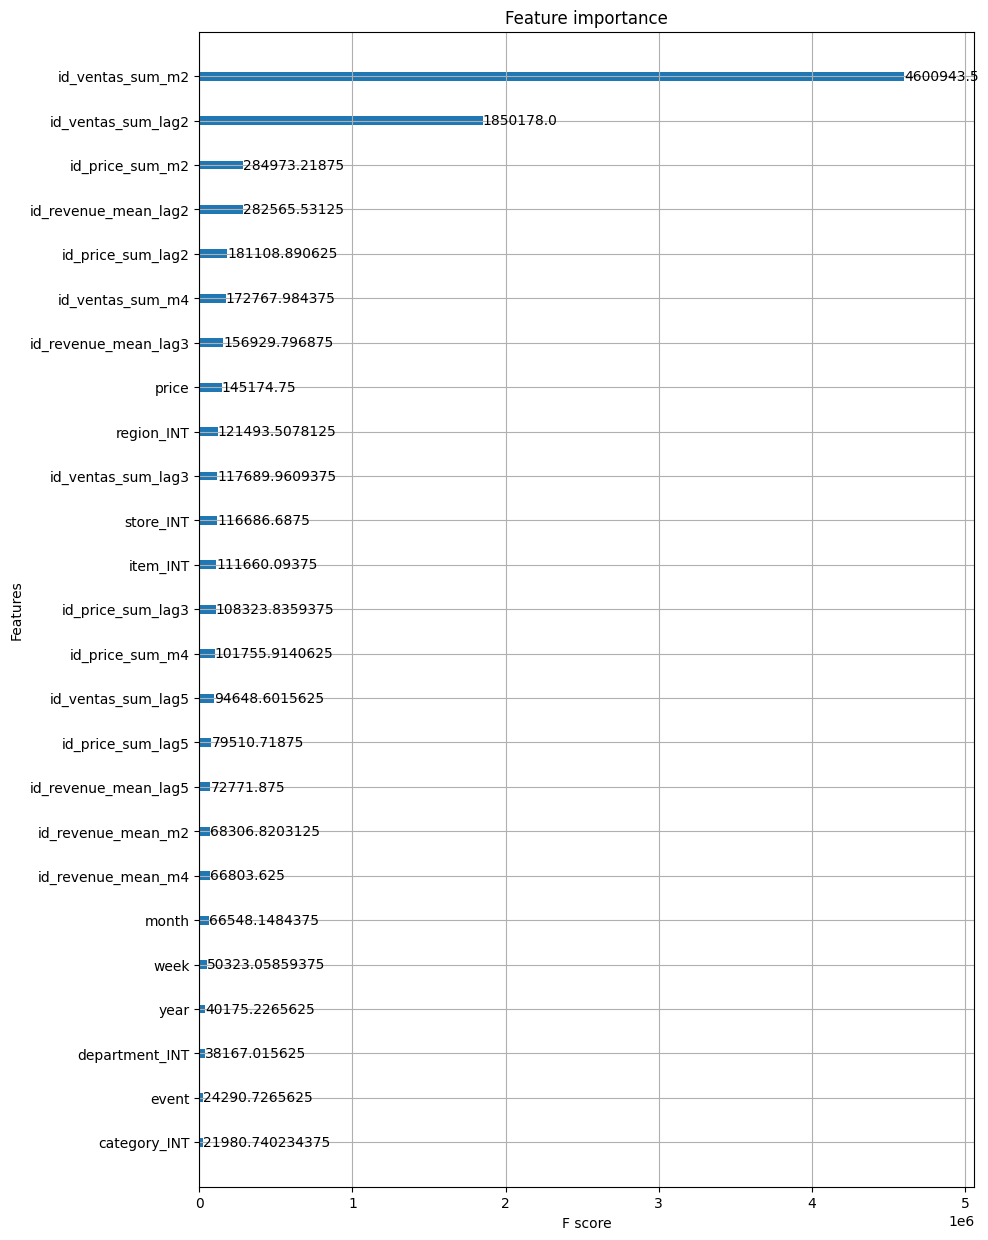

In [55]:
importance = model.get_booster().get_score(importance_type = 'gain')
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, importance_type = 'gain', ax = ax);

# Prediction

In [56]:
if 'ventas' in X_test.columns:
  X_test.drop('ventas', axis = 1, inplace = True)

In [57]:
Y_test_predict = pd.DataFrame(model.predict(X_test),columns = ['Prediction'],index = X_test.index)
X_test['ventas_prediccion'] = Y_test_predict

In [58]:
Y_test_predict

,Prediction
id,
ACCESORIES_1_001_BOS_1,2.227468
ACCESORIES_1_001_BOS_1,2.686131
ACCESORIES_1_001_BOS_1,2.620234
ACCESORIES_1_001_BOS_1,2.146547
ACCESORIES_1_001_BOS_2,1.326780
...,...
SUPERMARKET_3_827_PHI_2,20.406393
SUPERMARKET_3_827_PHI_3,10.987527
SUPERMARKET_3_827_PHI_3,14.330381


In [59]:
X_test.reset_index(inplace=True)

In [60]:
X_test.head(5)

,id,event,price,category_INT,department_INT,store_INT,region_INT,item_INT,year,week,...,id_price_sum_lag3,id_price_sum_lag5,id_price_sum_m2,id_price_sum_m4,id_revenue_mean_lag2,id_revenue_mean_lag3,id_revenue_mean_lag5,id_revenue_mean_m2,id_revenue_mean_m4,ventas_prediccion
0,ACCESORIES_1_001_BOS_1,0,10.9858,0,0,7,0,0,2016,13,...,10.9858,10.9858,10.9858,10.9858,21.9716,32.9574,21.9716,29.295467,25.633533,2.227468
1,ACCESORIES_1_001_BOS_1,0,10.9858,0,0,7,0,0,2016,14,...,10.9858,10.9858,10.9858,10.9858,21.9716,21.9716,32.9574,25.633533,29.295467,2.686131
2,ACCESORIES_1_001_BOS_1,0,10.9858,0,0,7,0,0,2016,15,...,10.9858,10.9858,10.9858,10.9858,21.9716,21.9716,32.9574,21.971600,29.295467,2.620234
3,ACCESORIES_1_001_BOS_1,0,10.9858,0,0,7,0,0,2016,16,...,10.9858,10.9858,10.9858,10.9858,21.9716,21.9716,21.9716,21.971600,25.633533,2.146547
4,ACCESORIES_1_001_BOS_2,0,10.9858,0,0,6,0,0,2016,13,...,10.9858,10.9858,10.9858,10.9858,21.9716,10.9858,21.9716,14.647733,14.647733,1.326780


In [61]:
# Creamos una tabla con la predicción en Test, las ventas en ese periodo, calculamos la diferencia e insertamos las fechas para saber donde se equivoca más

In [62]:
df_anios_final.set_index('id',inplace=True)
Y_test_prueba = df_anios_final[df_anios_final['date'].isin(test_index)][[TARGET]]
Y_test_prueba.rename(columns = {'ventas': 'ventas_a_predecir'},inplace=True)

In [63]:
Y_test_frame = Y_test.to_frame()
results_df = pd.concat([Y_test_predict, Y_test_frame],axis=1)
results_df['diferencia'] = results_df['Prediction']-results_df['ventas']
results_df = pd.concat([results_df,fechas_test],axis=1)
results_df.sort_values(by='diferencia',ascending=False)

,Prediction,ventas,diferencia,date
id,,,,
SUPERMARKET_3_635_NYC_3,242.093063,0,242.093063,2016-04-10
SUPERMARKET_3_382_NYC_3,227.512070,10,217.512070,2016-04-03
SUPERMARKET_2_181_PHI_2,313.500702,103,210.500702,2016-04-24
SUPERMARKET_3_498_PHI_2,199.962509,0,199.962509,2016-04-24
SUPERMARKET_3_635_NYC_3,170.232010,0,170.232010,2016-04-17
...,...,...,...,...
SUPERMARKET_3_681_BOS_1,120.521141,357,-236.478859,2016-04-03
SUPERMARKET_2_360_PHI_2,257.544250,528,-270.455750,2016-04-17
SUPERMARKET_3_811_PHI_2,142.504333,423,-280.495667,2016-04-17


In [64]:
# Concatenamos los dataframe con los valores de Target y sus respectivas fechas que habíamos guardado antes, para poder plotear el resultado de la predicción

In [65]:
predict_ventas_fechas = pd.concat([Y_test_predict,fechas_test],axis=1)
ventas_apredecir_fechas = pd.concat([Y_test_frame,fechas_test],axis=1)
ventas_train_fechas = pd.concat([Y_train,fechas_train],axis=1)
ventas_valida_fechas = pd.concat([Y_valida,fechas_valida],axis=1)

In [66]:
predict_plot_diff = predict_ventas_fechas.set_index('date').resample('W')['Prediction'].sum()
apredecir_plot_diff = ventas_apredecir_fechas.set_index('date').resample('W')['ventas'].sum()
train_plot_diff = ventas_train_fechas.set_index('date').resample('W')['ventas'].sum()
valida_plot_diff = ventas_valida_fechas.set_index('date').resample('W')['ventas'].sum()

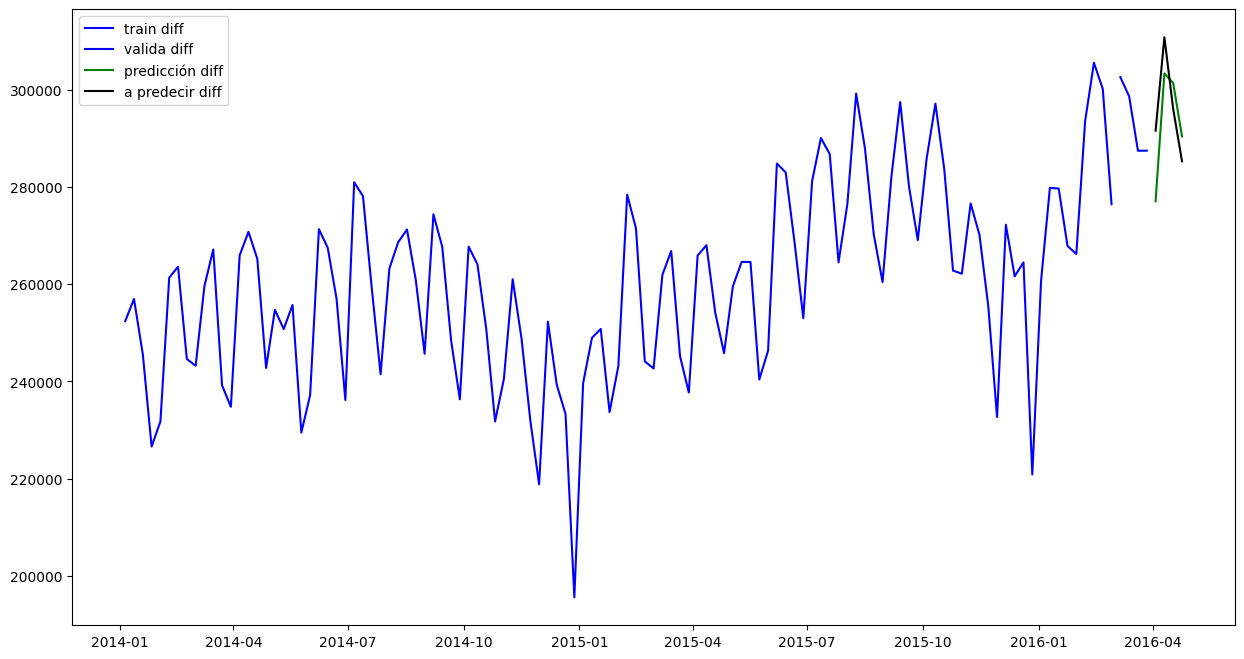

In [67]:
fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()
ax.plot(train_plot_diff, color = "blue", label = 'train diff')
ax.plot(valida_plot_diff, color = "blue",label = 'valida diff')
ax.plot(predict_plot_diff, color = "green", label = 'predicción diff')
ax.plot(apredecir_plot_diff, color = "black", label = 'a predecir diff')

ax.legend()

In [68]:
# Observamos donde nuestro modelo falla más

In [69]:
resultado_mayor_error = results_df[(results_df['diferencia']>= 5) | (results_df['diferencia']<= -5)].sort_values(by='diferencia',ascending = False)

In [70]:
resultado_mayor_error.index.nunique()

10973

In [71]:
resultado_mayor_error

,Prediction,ventas,diferencia,date
id,,,,
SUPERMARKET_3_635_NYC_3,242.093063,0,242.093063,2016-04-10
SUPERMARKET_3_382_NYC_3,227.512070,10,217.512070,2016-04-03
SUPERMARKET_2_181_PHI_2,313.500702,103,210.500702,2016-04-24
SUPERMARKET_3_498_PHI_2,199.962509,0,199.962509,2016-04-24
SUPERMARKET_3_635_NYC_3,170.232010,0,170.232010,2016-04-17
...,...,...,...,...
SUPERMARKET_3_681_BOS_1,120.521141,357,-236.478859,2016-04-03
SUPERMARKET_2_360_PHI_2,257.544250,528,-270.455750,2016-04-17
SUPERMARKET_3_811_PHI_2,142.504333,423,-280.495667,2016-04-17


In [72]:
print ('Nuestro modelo no es válido para algunos productos, estos suponen el', round((results_df[(results_df['diferencia']>= 5) | (results_df['diferencia']<= -5)].shape[0]/results_df.shape[0])*100,2),'% del total de predicciones hechas')

Nuestro modelo no es válido para algunos productos, estos suponen el 17.66 % del total de predicciones hechas


In [73]:
# Observamos donde nuestro modelo predice mejor

In [74]:
mejores_predicciones_modelo = results_df[(results_df['diferencia']<5) & (results_df['diferencia']>-5)]
mejores_predicciones_modelo.reset_index(inplace=True)
mejores_predicciones_modelo

,id,Prediction,ventas,diferencia,date
0,ACCESORIES_1_001_BOS_1,2.227468,2,0.227468,2016-04-03
1,ACCESORIES_1_001_BOS_1,2.686131,2,0.686131,2016-04-10
2,ACCESORIES_1_001_BOS_1,2.620234,2,0.620234,2016-04-17
3,ACCESORIES_1_001_BOS_1,2.146547,4,-1.853453,2016-04-24
4,ACCESORIES_1_001_BOS_2,1.326780,3,-1.673220,2016-04-03
...,...,...,...,...,...
100422,SUPERMARKET_3_827_BOS_3,8.428458,5,3.428458,2016-04-03
100423,SUPERMARKET_3_827_BOS_3,8.700952,5,3.700952,2016-04-24
100424,SUPERMARKET_3_827_NYC_4,9.226086,7,2.226086,2016-04-10
100425,SUPERMARKET_3_827_PHI_1,23.563757,20,3.563757,2016-04-17


In [75]:
print ('Nuestro modelo gweraliza bien para el ',round(results_df[(results_df['diferencia']<5) & (results_df['diferencia']>-5)].shape[0]/results_df.shape[0]*100,2),'% del total de predicciones hechas')

Nuestro modelo gweraliza bien para el  82.34 % del total de predicciones hechas


In [76]:
folder_path = "..\models"
file_name = "model_predict.pkl"
file_path = os.path.join(folder_path, file_name)

# Asegúrate de que la carpeta exista; si no, créala.
os.makedirs(folder_path, exist_ok=True)

# Guarda el modelo en el archivo especificado.
try:
    with open(file_path, "wb") as file:
        pickle.dump(model, file)
    print("Model saved successfully at:", file_path)
except Exception as e:
    print("Error:", e)

Model saved successfully at: ..\models\model_predict.pkl


In [77]:
# Agrupamos las predicciones semanales en un mes por cada id. Así observar el comportamiento durante todo el período y ver si generaliza mejor

In [78]:
predicciones_mensuales = (
    results_df.set_index('date')
    .groupby(results_df.index)
    .resample('M')
    .agg(
    suma_predicciones = ('Prediction',np.sum),
    suma_ventas_predecir = ('ventas',np.sum)
).round(2)
)

In [79]:
predicciones_mensuales.reset_index(inplace=True)

In [80]:
predicciones_mensuales['error'] = predicciones_mensuales['suma_predicciones']-predicciones_mensuales['suma_ventas_predecir']

In [81]:
predicciones_mensuales[predicciones_mensuales['error']>50].sort_values(by = 'error',ascending = False)

,id,date,suma_predicciones,suma_ventas_predecir,error
26065,SUPERMARKET_3_382_NYC_3,2016-04-30,579.070007,17,562.070007
28595,SUPERMARKET_3_635_NYC_3,2016-04-30,611.979980,113,498.979980
24762,SUPERMARKET_3_252_BOS_3,2016-04-30,1282.589966,915,367.589966
28102,SUPERMARKET_3_586_BOS_3,2016-04-30,1976.410034,1631,345.410034
28112,SUPERMARKET_3_587_BOS_3,2016-04-30,907.250000,569,338.250000
...,...,...,...,...,...
28382,SUPERMARKET_3_614_BOS_3,2016-04-30,53.380001,3,50.380001
28186,SUPERMARKET_3_594_NYC_4,2016-04-30,54.360001,4,50.360001
26385,SUPERMARKET_3_414_NYC_3,2016-04-30,65.260002,15,50.260002
30082,SUPERMARKET_3_787_BOS_3,2016-04-30,154.169998,104,50.169998


In [82]:
predicciones_mensuales['date'].unique()

<DatetimeArray>
['2016-04-30 00:00:00']
Length: 1, dtype: datetime64[ns]

In [83]:
# Cálculamos el RMSE

In [84]:
X_test_rmse = X_test.iloc[:,:-1]
X_test_rmse.set_index('id',inplace=True)

In [85]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)
Y_test_predict = model.predict(X_test_rmse)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)


rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_test = np.sqrt(
    mean_squared_error(
        y_true = Y_test,
        y_pred = Y_test_predict
    )
)

rmse_train = str(round(rmse_train,3)).replace('.','_')
rmse_valida = str(round(rmse_valida,3)).replace('.','_')
rmse_test = str(round(rmse_test,3)).replace('.','_')

In [86]:
print(f'Train RMSE: {rmse_train}')
print(f'Validation RMSE: {rmse_valida}')
print(f'Test RMSE: {rmse_test}')

Train RMSE: 8_898
Validation RMSE: 9_278
Test RMSE: 8_333


# Comparación donde nuestro modelo predice mejor y peor, observando las gráficas

In [87]:
df_anios_final.reset_index(inplace=True)

<Axes: title={'center': 'Id donde nuestro modelo predice mejor'}, xlabel='date'>

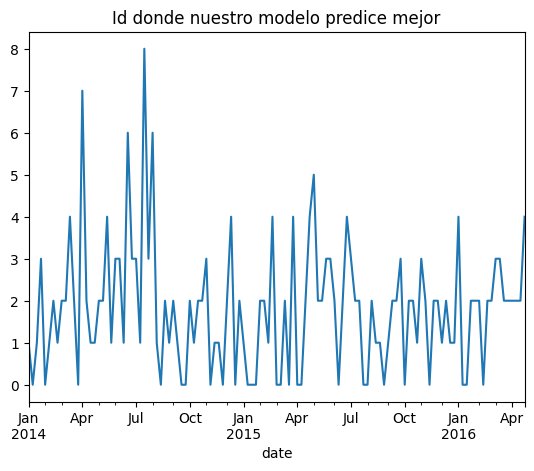

In [88]:
df_anios_final[df_anios_final['id']== 'ACCESORIES_1_001_BOS_1'].set_index('date').resample('W')['ventas'].sum().plot(title = 'Id donde nuestro modelo predice mejor')   # Nuestro modelo predice muy bien aquí

<Axes: title={'center': 'Id donde nuestro modelo se predice peor'}, xlabel='date'>

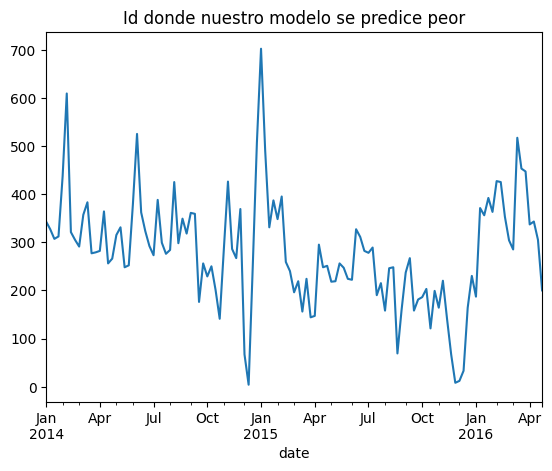

In [89]:
df_anios_final[df_anios_final['id']== 'SUPERMARKET_3_282_NYC_3'].set_index('date').resample('W')['ventas'].sum().plot(title = 'Id donde nuestro modelo se predice peor')  # Nuestro modelo NO predice muy bien aquí

<Axes: title={'center': 'Id donde nuestro modelo se predice peor'}, xlabel='date'>

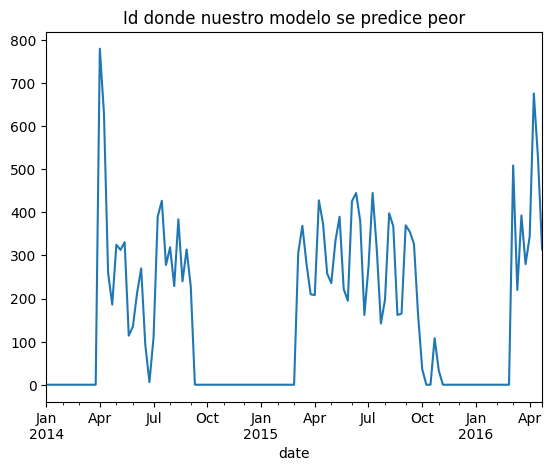

In [90]:
df_anios_final[df_anios_final['id']== 'SUPERMARKET_2_360_PHI_2'].set_index('date').resample('W')['ventas'].sum().plot(title = 'Id donde nuestro modelo se predice peor')   # Nuestro modelo NO predice muy bien aquí

# Convertir DFs a csv y descarga

In [91]:
# Predicciones agrupadas en un mes por id

In [92]:
### Descomenta para descargar el CSV 

# predicciones_mensuales.to_csv('predicciones_mensuales.csv',index=False)
# webbrowser.open('predicciones_mensuales.csv')

In [93]:
# Predicciones semanales por id

In [94]:
### Descomenta para descargar el CSV 

# results_df.to_csv('results_df.csv')
# webbrowser.open('results_df.csv')

In [95]:
# Predicciones donde nuestro modelo se equivoca mucho

In [96]:
### Descomenta para descargar el CSV 

# resultado_mayor_error.to_csv('resultado_mayor_error.csv')
# webbrowser.open(f'resultado_mayor_error.csv')

In [97]:
# Predicciones donde nuestro modelo predice mejor

In [98]:
### Descomenta para descargar el CSV 

# mejores_predicciones_modelo.to_csv('mejores_predicciones_modelo.csv',index=False)
# webbrowser.open(f'mejores_predicciones_modelo.csv')